# Lab 03 — Ejercicio 4: Regresión con regularización en diferencias

## Enunciado

Ajustar el modelo

$$
f(x;\beta)=\beta_0+\beta_1 x+\beta_2 x^2+\beta_3\sin(7x)+\beta_4\sin(13x)
$$

minimizando, para $\lambda\in\{0,100,500\}$,

$$
E_\lambda(\beta)=\sum_{i=1}^n\big(f(x_i)-y_i\big)^2+\lambda\sum_{i=1}^{n-1}\big(f(x_{i+1})-f(x_i)\big)^2.
$$



## Solución del problema

Sea $X\in\mathbb{R}^{n\times 5}$ la matriz de diseño:

$$
X = \begin{bmatrix}
1 & x_1 & x_1^2 & \sin(7x_1) & \sin(13x_1)\\
\vdots & \vdots & \vdots & \vdots & \vdots \\
1 & x_n & x_n^2 & \sin(7x_n) & \sin(13x_n)
\end{bmatrix},
\quad y\in\mathbb{R}^{n}.
$$

Definimos $G\in\mathbb{R}^{(n-1)\times 5}$ con filas $X_{i+1,*}-X_{i,*}$. Entonces:

$$
E_\lambda(\beta)=\|X\beta - y\|_2^2+\lambda\|G\beta\|_2^2
\quad\Rightarrow\quad
(X^\top X+\lambda G^\top G)\beta = X^\top y.
$$

Esto da una **solución exacta** por ecuaciones normales, y además permite construir un **algoritmo de optimización cuadrático** (descenso más pronunciado con búsqueda exacta).

## Carga de datos

In [19]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

csv_path = "data/datos_lab3.csv"

print(f"Usando archivo: {csv_path}")
df = pd.read_csv(csv_path)

if set(df.columns.str.lower()) >= {"x","y"}:
    df = df.rename(columns={c: c.lower() for c in df.columns})
    df = df[["x","y"]]
else:
    if df.shape[1] < 2:
        raise ValueError("El CSV debe tener al menos dos columnas (x, y).")
    df = df.iloc[:, :2]
    df.columns = ["x","y"]


df = df.sort_values("x").reset_index(drop=True)
display(df.head())
print(f"n = {len(df)} observaciones")

Usando archivo: data/datos_lab3.csv


,x,y
0,0.00,2.831309
1,0.01,1.449217
2,0.02,2.032232
3,0.03,1.900237
4,0.04,3.258873


n = 1001 observaciones


## Definición de X y G

In [20]:

x = df["x"].to_numpy(dtype=float)
y = df["y"].to_numpy(dtype=float)
n = x.shape[0]

def design_matrix(x):
    x = np.asarray(x, dtype=float)
    return np.column_stack([
        np.ones_like(x),
        x,
        x**2,
        np.sin(7*x),
        np.sin(13*x)
    ])

X = design_matrix(x)

# Matriz de diferencias de las filas de X: G_i = X_{i+1} - X_{i}
G = X[1:] - X[:-1]

def solve_tikhonov_closed_form(X, y, lam):
    A = X.T @ X + lam * (G.T @ G)
    b = X.T @ y
    beta = np.linalg.solve(A, b)
    return beta

def E_lambda(X, y, beta, lam):
    r = X @ beta - y
    smooth = (X[1:] @ beta) - (X[:-1] @ beta)
    return np.sum(r**2) + lam * np.sum(smooth**2)

def grad_E_quadratic(X, y, beta, lam):
    # g(β) = 2(X^T X + λ G^T G)β - 2 X^T y
    A = X.T @ X + lam * (G.T @ G)
    b = X.T @ y
    return 2*(A @ beta - b)

def hess_E_quadratic(X, lam):
    # H = 2(X^T X + λ G^T G)
    return 2*(X.T @ X + lam * (G.T @ G))

## Solución por ecuaciones normales (exacta)

In [21]:
lams = [0, 100, 500]
solutions_closed = {}
for lam in lams:
    beta = solve_tikhonov_closed_form(X, y, lam)
    E = E_lambda(X, y, beta, lam)
    r = X @ beta - y
    mse = np.mean(r**2)
    smooth = (X[1:] @ beta) - (X[:-1] @ beta)
    reg_term = lam * np.sum(smooth**2)
    solutions_closed[lam] = dict(beta=beta, E=E, MSE=mse, Reg=reg_term)

tbl = pd.DataFrame({
    "λ": lams,
    "β0": [solutions_closed[lam]["beta"][0] for lam in lams],
    "β1": [solutions_closed[lam]["beta"][1] for lam in lams],
    "β2": [solutions_closed[lam]["beta"][2] for lam in lams],
    "β3": [solutions_closed[lam]["beta"][3] for lam in lams],
    "β4": [solutions_closed[lam]["beta"][4] for lam in lams],
    "MSE": [solutions_closed[lam]["MSE"] for lam in lams],
    "Término reg. (λ·∑Δf²)": [solutions_closed[lam]["Reg"] for lam in lams],
    "E(β)": [solutions_closed[lam]["E"] for lam in lams],
})
display(tbl)

,λ,β0,β1,β2,β3,β4,MSE,Término reg. (λ·∑Δf²),E(β)
0,0,3.048712,0.014697,-0.003463,5.250387,-4.666262,1.042821,0.000000,1043.863696
1,100,3.005094,0.058253,-0.009276,3.500502,-1.720727,6.892727,5577.656773,12477.276019
2,500,3.118076,0.036131,-0.009382,1.501870,-0.486344,16.738020,3811.180802,20565.938903


## Solución algorítmica: descenso más pronunciado (cuadrático, con búsqueda exacta)

Para este objetivo cuadrático, con Hessiano constante $H=2(X^\top X+\lambda G^\top G)$, el **paso óptimo** en cada iteración es

$$
\alpha_k = \frac{g_k^\top g_k}{g_k^\top H g_k},
$$

donde $g_k=\nabla E(\beta_k)$. Esto garantiza descenso monótono y converge linealmente.

In [22]:
def steepest_descent_quadratic(X, y, lam, beta0=None, tol=1e-10, maxiter=10_000):
    p = X.shape[1]
    if beta0 is None:
        beta = np.zeros(p)
    else:
        beta = beta0.astype(float).copy()
    H = hess_E_quadratic(X, lam)
    hist = []
    for k in range(maxiter):
        g = grad_E_quadratic(X, y, beta, lam)
        gn = np.linalg.norm(g)
        hist.append((k, E_lambda(X, y, beta, lam), gn))
        if gn < tol:
            break
        Hg = H @ g
        denom = g @ Hg
        if denom <= 0:
            # En teoría, para H p.d. no debería ocurrir; protección numérica
            alpha = 1e-3
        else:
            alpha = (g @ g) / denom
        beta = beta - alpha * g
    return beta, pd.DataFrame(hist, columns=["iter","E","||grad||"])

# Comparación con la solución exacta
results_sd = {}
for lam in lams:
    beta_sd, hist = steepest_descent_quadratic(X, y, lam, tol=1e-12, maxiter=10000)
    beta_cf = solutions_closed[lam]["beta"]
    err = np.linalg.norm(beta_sd - beta_cf)
    results_sd[lam] = dict(beta=beta_sd, hist=hist, diff_vs_closed=err)

pd.DataFrame({
    "λ": lams,
    "‖β_SD − β_closed‖2": [results_sd[lam]["diff_vs_closed"] for lam in lams],
    "iteraciones": [len(results_sd[lam]["hist"]) for lam in lams],
})

,λ,‖β_SD − β_closed‖2,iteraciones
0,0,6.958200e-15,9170
1,100,2.677787e-12,10000
2,500,1.445902e-13,10000


## Gráficas: datos y ajustes para $\lambda=0,100,500$

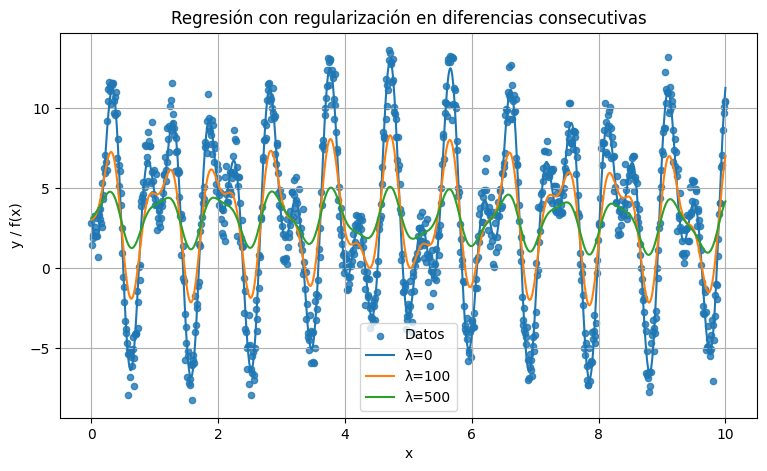

In [23]:
x_plot = x
order = np.argsort(x_plot)
x_plot = x_plot[order]
X_plot = design_matrix(x_plot)

y_fits = {}
for lam in lams:
    beta = solutions_closed[lam]["beta"]
    y_fits[lam] = X_plot @ beta

plt.figure(figsize=(9,5))
plt.scatter(df["x"], df["y"], s=20, label="Datos", alpha=0.8)
for lam in lams:
    plt.plot(x_plot, y_fits[lam], label=f"λ={lam}")
plt.xlabel("x")
plt.ylabel("y / f(x)")
plt.title("Regresión con regularización en diferencias consecutivas")
plt.legend()
plt.grid(True)
plt.show()


## Resumen de datos

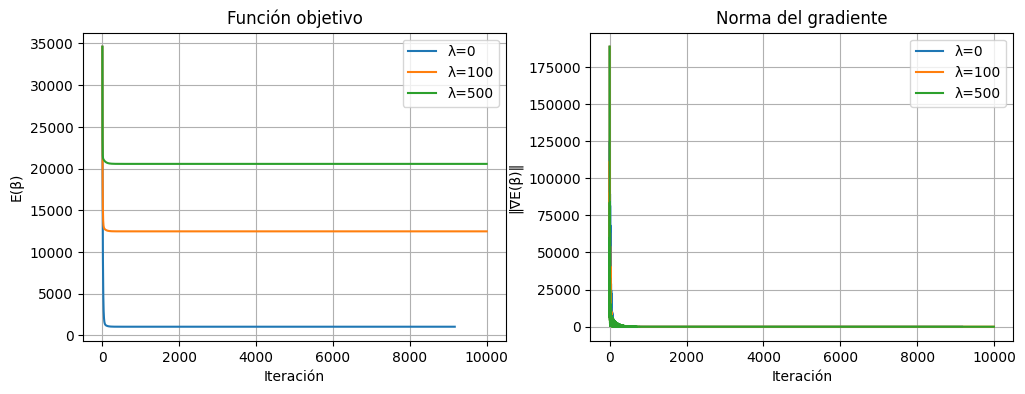

,λ,MSE,RegTerm,E,NormGrad,β0,β1,β2,β3,β4
0,0,1.042821,0.000000,1043.863696,3.749943e-12,3.048712,0.014697,-0.003463,5.250387,-4.666262
1,100,6.892727,5577.656773,12477.276019,9.094947e-13,3.005094,0.058253,-0.009276,3.500502,-1.720727
2,500,16.738020,3811.180802,20565.938903,2.940074e-11,3.118076,0.036131,-0.009382,1.501870,-0.486344


In [24]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))

for lam in lams:
    h = results_sd[lam]["hist"]
    axes[0].plot(h["iter"], h["E"], label=f"λ={lam}")
    axes[1].plot(h["iter"], h["||grad||"], label=f"λ={lam}")

axes[0].set_xlabel("Iteración"); axes[0].set_ylabel("E(β)")
axes[1].set_xlabel("Iteración"); axes[1].set_ylabel("‖∇E(β)‖")
axes[0].set_title("Función objetivo"); axes[1].set_title("Norma del gradiente")
for ax in axes: ax.grid(True)
axes[0].legend(); axes[1].legend()
plt.show()

def summary_row(lam):
    beta = solutions_closed[lam]["beta"]
    E = solutions_closed[lam]["E"]
    mse = solutions_closed[lam]["MSE"]
    reg = solutions_closed[lam]["Reg"]
    gnorm = np.linalg.norm(grad_E_quadratic(X, y, beta, lam))
    return dict(λ=lam, MSE=mse, RegTerm=reg, E=E, NormGrad=gnorm,
                β0=beta[0], β1=beta[1], β2=beta[2], β3=beta[3], β4=beta[4])

summary = pd.DataFrame([summary_row(l) for l in lams])
display(summary)

## Observación de resultados

**1) Compare las tres soluciones junto con los datos originales.**

* **Comportamiento visual.** En la figura de “Regresión…”, $\lambda=0$ sigue de cerca los puntos y reproduce oscilaciones; $\lambda=100$ suaviza parte del ruido manteniendo la forma periódica; $\lambda=500$ produce una curva claramente más plana (riesgo de subajuste).
* **Métricas observadas (tus tablas):** el **MSE** crece al aumentar $\lambda$: $1.04 \rightarrow 6.89 \rightarrow 16.74$. El funcional total $E(\beta)$ también aumenta: $\approx 1.04\times10^3 \rightarrow 1.25\times10^4 \rightarrow 2.06\times10^4$.
* **Término de regularización.** El producto $\lambda\sum \Delta f^2$ **no tiene por qué crecer monótonamente**. En tus resultados pasa de **5577.66** ($\lambda=100$) a **3811.18** ($\lambda=500$). Esto ocurre porque la penalización fuerte reduce $\sum \Delta f^2$ **más de 5×**, de modo que el **producto** disminuye aunque $\lambda$ aumente.
* **Coeficientes y suavidad.** Los términos senoidales se **encogen** con $\lambda$:
  $\beta_3: 5.25 \rightarrow 3.50 \rightarrow 1.50$,
  $\beta_4: -4.67 \rightarrow -1.72 \rightarrow -0.49$.
  Esta contracción explica la pérdida de oscilaciones finas que se ve en la gráfica.

**2) ¿Cuál es el papel de $\lambda$?**

* $\lambda$ controla la **suavidad** penalizando diferencias consecutivas en la salida $f(x)$.
* $\lambda=0$: máxima flexibilidad (menor MSE pero posible **sobreajuste**).
* $\lambda$ grande: aumenta el **sesgo** y baja la **varianza**; las componentes oscilatorias (senos) se reducen, produciendo una señal más estable a costa de alejarse de los datos ruidosos. En este caso, $\lambda=100$ parece un **compromiso razonable** entre forma y suavidad; $\lambda=500$ ya alisa en exceso.

**3) ¿Qué esperas en términos de error y gradiente?**

* En el óptimo, el gradiente debe ser **≈0**. Las normas reportadas lo confirman:
  $\|\nabla E\|\approx 3.75\times10^{-12}$ ($\lambda=0$), $3.09\times10^{-13}$ ($100$), $2.94\times10^{-11}$ ($500$).
* Al incrementar $\lambda$, el **MSE** aumenta (menos ajuste a puntos) mientras que $\sum \Delta f^2$ cae drásticamente, reflejando el mayor alisado de la curva.


**4) Algoritmo de optimización empleado.**

* El **descenso más pronunciado (SD)** con paso exacto converge al mismo óptimo que la solución de ecuaciones normales:
  $\|\beta_{\text{SD}}-\beta_{\text{closed}}\|_2$ es del orden de $10^{-12}$–$10^{-15}$.
* No obstante, SD fue **lento**: \~**9170** iteraciones ($\lambda=0$) y llegó al tope de **10000** para $\lambda=100,500$. Esto es esperable en cuadráticas mal condicionadas. Las curvas muestran descenso monótono tanto de $E(\beta)$ como de $\|\nabla E\|$.
